<a href="https://colab.research.google.com/github/anirbanroy987/APPLIED-AI-ML-ASSIGNMENTS/blob/master/Ensembles_and_RandomForest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## How is it 75% ?
If you have an ensemble of $1000$ classifiers that are individually correct only $51\%$ of the time, by using majority voting, you can hope for up to $75\%$ accuracy.

In [ ]:
from scipy.stats import binom
num_clfs = 1000
p_acc = 0.51

In [ ]:
# define the distribution
dist = binom(num_clfs, p_acc)

# We can't tolerate more than 499 classifiers being incorrect
minority = 499

# P(X <= minority) = P(X <= minority number of successes) => We'd choose 
# incorrectly via majority voting
p_failure = dist.cdf(minority)

# Max Accuracy = 1 - P(X <= minority)
max_acc = (1. - p_failure) * 100
print('Max Accuracy of %d classifiers with %.3f accuracy each is %.3f%%' % (num_clfs, p_acc, max_acc))


Max Accuracy of 1000 classifiers with 0.510 accuracy each is 74.675%


## Bagging vs Pasting

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
def label(x, y, text):
    y = y + 0.05  # shift y-value for label so that it's below the artist
    plt.text(x, y, text, ha="center", family='sans-serif', size=14)

def plot_samples(X, y,alpha=0.5):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    for i in range(len(X)):
      label(X[i, 0], X[i, 1], "{}".format(int(X[i,2])))
    plt.axis([-3, 3, -3, 3])
    plt.tight_layout()
    

(75, 3)


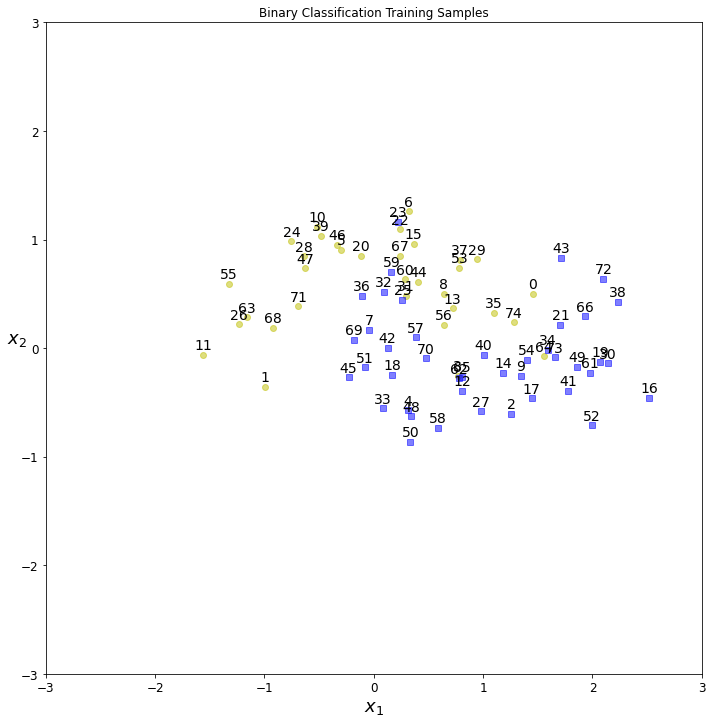

In [ ]:
plt.figure(figsize=(10,10))
idxs = np.array([range(len(X_train))])
idxs = idxs.reshape(-1, 1)
X_train=np.hstack((X_train, idxs))
print(X_train.shape)
plot_samples(X_train, y_train)
plt.title("Binary Classification Training Samples");

### Bagging
Notice that some samples are drawn again when re-running the experiment

In [ ]:
def bagging_samples(data, n_samples):
    indices = np.random.randint(0, len(data), min(n_samples, len(data)))
    samples = data[indices]
    return samples

In [ ]:
data = np.hstack((X_train, y_train.reshape(-1, 1)))
def run_bag_expt(data, num_samples=30):
  bagged_data = bagging_samples(data, num_samples)
  X_bagged, y_bagged = bagged_data[:,:3], bagged_data[:, 3]
  plt.figure(figsize=(6,6))
  plot_samples(X_bagged, y_bagged)
  plt.title("Bagged Training Samples");

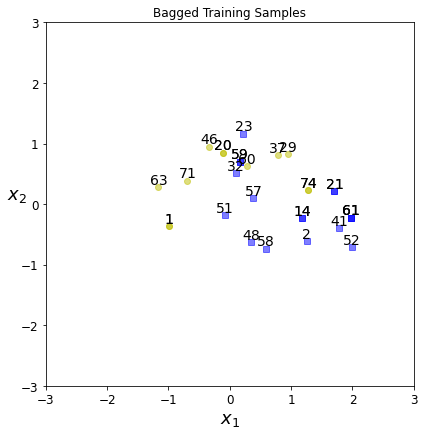

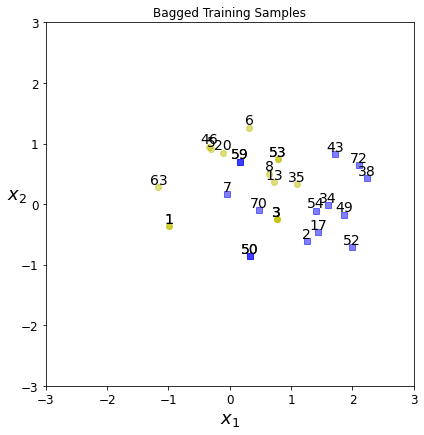

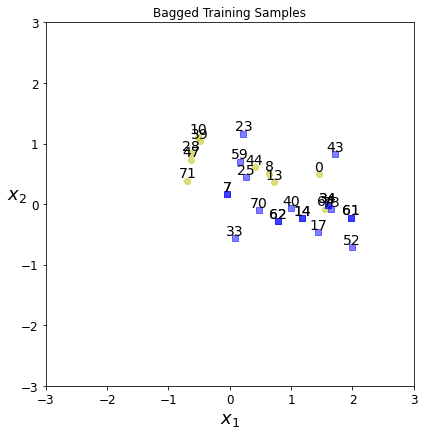

In [ ]:
for i in range(3):
  run_bag_expt(data)

### Pasting
Here, the samples drawn in each run is different

In [ ]:
used_ids = []
def pasting_samples(data, num_samples):
  ids = data[:,2]
  unused_ids = [id for id in ids.ravel() if id not in set(used_ids)]
  data = data[np.where(np.isin(data[:,2], unused_ids))]
  pasted_data = bagging_samples(data, num_samples)
  used_ids.extend(pasted_data[:,2])
  return pasted_data

def run_paste_expt(data, num_samples=30):
  pasted_data = pasting_samples(data, num_samples)
  X_pasted, y_pasted = pasted_data[:,:3], pasted_data[:, 3]
  plt.figure(figsize=(6,6))
  plot_samples(X_pasted, y_pasted)
  plt.title("Pasted Training Samples");

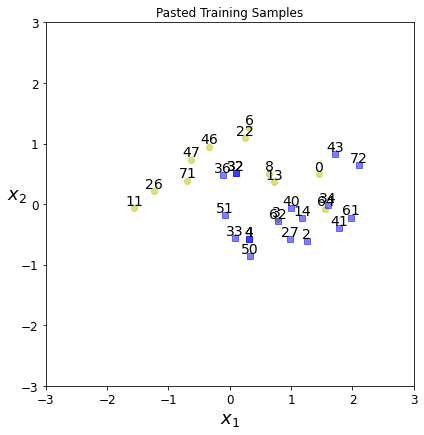

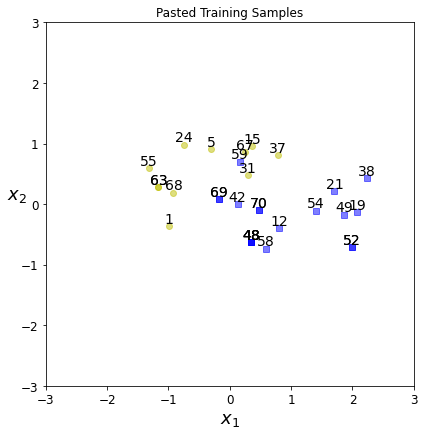

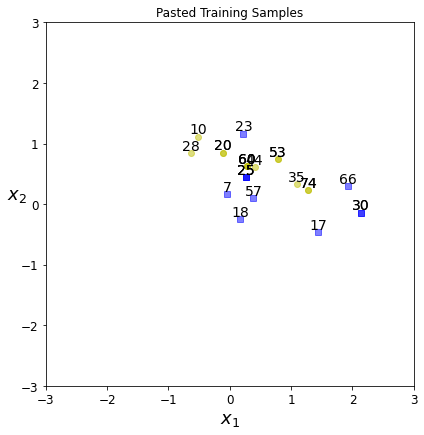

In [ ]:
for i in range(3):
  run_paste_expt(data)

## Out of Bag Evaluation vs K-Fold CV

The OOB Evaluation gives us a good indication of what to expect and is a strong signal. Below we can see that it correlates nicely with a K-Fold CV run

Some useful further reading: https://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_oob.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-oob-py

In [ ]:
# Recreate larger dataset
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

### Out of Bag Evaluation

In [ ]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.9013333333333333

### K-Fold CV

In [ ]:
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score

cv = KFold(n_splits=5)

for train, test in cv.split(X_train, y_train):
  bag_clf.fit(X_train[train], y_train[train])
  y_pred = bag_clf.predict(X_train[test])
  print(accuracy_score(y_train[test], y_pred))

0.8666666666666667
0.9333333333333333
0.9066666666666666
0.9333333333333333
0.88
